## load and prepare the data

In [1]:
# !pip install -U scikit-fuzzy==0.5.0

In [2]:
import os

import pandas as pd

from matplotlib import pyplot as plt

from IPython.display import display, HTML

In [3]:
data_path = os.path.join('..', '..', 'data')

In [4]:


fp = os.path.join(data_path, 'labeled', 'manifesto_sentences_predicted_social_group_mentions_with_noneconomic_attributes_classifications.tsv')
# NOTE: you could also load the file with mention's predicted attribute dimension classifications

df = pd.read_csv(fp, sep='\t') # , usecols=['sentence_id', 'span_nr', 'text', 'label'])

In [5]:
max_spans = df['span_nr'].max()
df['mention_id'] = df['sentence_id'].astype(str) + '-' + df['span_nr'].astype(str).str.zfill(len(str(max_spans)))
# del df['sentence_id']
# del df['span_nr']

In [6]:
# subset to social group mentions
df = df[df.group_type == 'social group']

In [7]:
# remove group type labels (not needed)
del df['group_type']

In [8]:
label_cols = df.columns[df.columns.str.startswith('noneconomic__')].to_list()

In [9]:
df[label_cols].sum(axis=0)

noneconomic__age                          25687
noneconomic__crime                         6245
noneconomic__ethnicity                     1997
noneconomic__family                       22376
noneconomic__gender_sexuality              9632
noneconomic__health                        8901
noneconomic__nationality                  34265
noneconomic__place_location                5958
noneconomic__religion                       823
noneconomic__shared_values_mentalities     9231
dtype: int64

In [10]:
# within-dimension intersectionality at mention level?
df[label_cols].sum(axis=1).value_counts(normalize=True)

0    0.504416
1    0.400476
2    0.088593
3    0.006119
4    0.000368
5    0.000029
Name: proportion, dtype: float64

In [11]:
# within-dimension intersectionality at sentence level?
tmp = df.groupby('sentence_id')[label_cols].max().reset_index()
tmp[label_cols].sum(axis=1).value_counts(normalize=True)

0    0.443516
1    0.399494
2    0.130106
3    0.022743
4    0.003465
5    0.000579
6    0.000084
7    0.000014
Name: proportion, dtype: float64

In [12]:
import regex
valid = df['text'].apply(lambda x: bool(regex.search(r'\p{L}', x)))
df = df[valid]

In [13]:
#!pip install mosestokenizer==1.2.1
from mosestokenizer import MosesPunctuationNormalizer

normalizer = MosesPunctuationNormalizer('en')

df['text'] = df.text.map(normalizer).str.replace(r'["\']', '', regex=True).str.strip()

In [14]:
# drop verbatim duplicates
mentions_df = df.groupby(['text', *label_cols]).agg({'mention_id': ('count', list)}).reset_index()

# flatten multindex
mentions_df.columns = ['text', *label_cols, 'n_mentions', 'mention_ids']

In [15]:
# how many mentions per noneconomic attribute category (inter-sectional mentions not considered?
mentions_df[label_cols].sum(axis=0)

noneconomic__age                           7485
noneconomic__crime                         3301
noneconomic__ethnicity                      974
noneconomic__family                        5421
noneconomic__gender_sexuality              2091
noneconomic__health                        3842
noneconomic__nationality                  13810
noneconomic__place_location                3795
noneconomic__religion                       520
noneconomic__shared_values_mentalities     7131
dtype: int64

In [16]:
# how many instances with intersectionality in noneconomic attributes?
mentions_df[label_cols].sum(axis=1).value_counts(normalize=True)
# NOTE: entries for ≥2 indicate intersectional mentions

0    0.442821
1    0.419896
2    0.122641
3    0.013482
4    0.001072
5    0.000088
Name: proportion, dtype: float64

In [17]:
# get co-occurrence matrix
import numpy as np
co_occurrence_matrix = np.dot(mentions_df[label_cols].T, mentions_df[label_cols]).astype(float)
# make diagonal 0
np.fill_diagonal(co_occurrence_matrix, np.nan)
# set values in upper triangle to nan (avoid double counting)
co_occurrence_matrix[np.triu_indices_from(co_occurrence_matrix, k=1)] = np.nan
labs=[l.removeprefix('noneconomic__').replace('shared_', '').replace('_', '/') for l in label_cols]
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=labs, columns=labs)

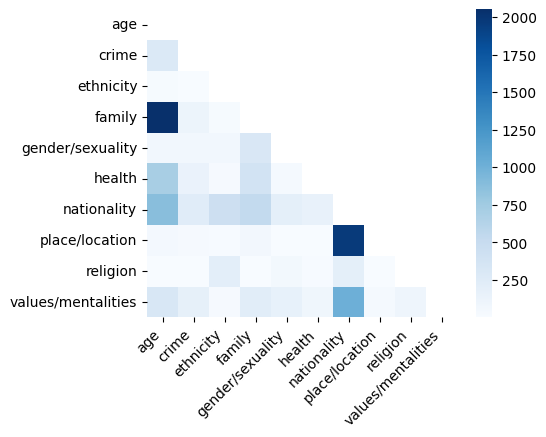

In [18]:
import seaborn as sns   
plt.figure(figsize=(5,4))
sns.heatmap(co_occurrence_df, annot=False, fmt='d', cmap='Blues')
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

## Embed the mentions

In [19]:
label_cols

['noneconomic__age',
 'noneconomic__crime',
 'noneconomic__ethnicity',
 'noneconomic__family',
 'noneconomic__gender_sexuality',
 'noneconomic__health',
 'noneconomic__nationality',
 'noneconomic__place_location',
 'noneconomic__religion',
 'noneconomic__shared_values_mentalities']

🚨 **<span style="color: red">Example:<span>** any mentions predicted to be in category "oneconomic__age"?

In [20]:
df_sample = mentions_df.query('noneconomic__age==1').copy()
len(df_sample)

7485

In [21]:
# NOTE: let's sample down to 2,000 mentions for faster processing
df_sample = df_sample.sample(2_000, random_state=42).reset_index(drop=True)

In [22]:
# NOTE: important to use same model here as for classification
embedding_model_name = './../../models/all-mpnet-base-v2_noneconomic-attributes-classifier'
# embedding_model_name = "google/embeddinggemma-300m"

In [23]:
import torch
from sentence_transformers import SentenceTransformer
import torch.backends
import torch.backends.mps

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

embedder = SentenceTransformer(embedding_model_name, device=device)

embeddings = embedder.encode(
    df_sample.text.to_list(), 
    normalize_embeddings=True, 
    convert_to_numpy=True,
    show_progress_bar=True,
)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

In [24]:
embedder.get_sentence_embedding_dimension()//10

76

In [25]:
# TODO: reduce dimensionality with UMAP before clustering to 40 dimensions
from umap import UMAP
n_low_dim = embedder.get_sentence_embedding_dimension()//10
umap_model = UMAP(n_components=n_low_dim, random_state=42, n_jobs=1)
reduced_embeddings = umap_model.fit_transform(embeddings)

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rescaled_reduced_embeddings = scaler.fit_transform(reduced_embeddings)

## Fuzzy clustering

### Metrics

In [27]:
def partition_coefficient(u_matrix):
    """
    Compute the Partition Coefficient (PC) for fuzzy clustering.
    
    PC = (1/N) * sum(sum(u_ik^2))
    
    Where:
    - N is the number of data points
    - u_ik is the membership degree of point i in cluster k
    
    Parameters:
    -----------
    u_matrix : numpy.ndarray
        Fuzzy membership matrix of shape (n_clusters, n_samples)
        
    Returns:
    --------
    pc : float
        Partition coefficient value between 1/c and 1, where c is number of clusters.
        Higher values indicate better clustering (more crisp assignments).
    """
    n_samples = u_matrix.shape[1]
    pc = np.sum(u_matrix**2) / n_samples
    return pc

def partition_entropy(u_matrix, base=np.e):
    """
    Compute the Partition Entropy (PE) for fuzzy clustering.
    
    PE = -(1/N) * sum(sum(u_ik * log(u_ik)))
    
    Where:
    - N is the number of data points
    - u_ik is the membership degree of point i in cluster k
    - log is the natural logarithm (or other base)
    
    Parameters:
    -----------
    u_matrix : numpy.ndarray
        Fuzzy membership matrix of shape (n_clusters, n_samples)
    base : float
        Logarithm base (default=np.e for natural log, use 2 for log2, 10 for log10)
        
    Returns:
    --------
    pe : float
        Partition entropy value between 0 and log_base(c), where c is number of clusters.
        Lower values indicate better clustering (more crisp assignments).
    """
    n_samples = u_matrix.shape[1]
    
    # Add small epsilon to avoid log(0) issues
    epsilon = 1e-15
    u_safe = np.maximum(u_matrix, epsilon)
    
    # Compute log with specified base
    if base == np.e:
        log_u = np.log(u_safe)
    elif base == 2:
        log_u = np.log2(u_safe)
    elif base == 10:
        log_u = np.log10(u_safe)
    else:
        log_u = np.log(u_safe) / np.log(base)
    
    # Calculate partition entropy
    pe = -np.sum(u_matrix * log_u) / n_samples
    return pe

def xie_beni_index(X, u_matrix, centers, m=2):
    """
    Compute the Xie-Beni Index (XB) for fuzzy clustering.
    
    XB = (sum_{i,k} u_ik^m * ||x_i - c_k||^2) / (N * min_{j≠k} ||c_j - c_k||^2)
    
    Where:
    - X is the data matrix (n_samples, n_features)
    - u_ik is the membership degree of point i in cluster k
    - c_k is the center of cluster k
    - m is the fuzziness parameter (typically 2)
    - N is the number of data points
    
    Parameters:
    -----------
    X : numpy.ndarray
        Data matrix of shape (n_samples, n_features)
    u_matrix : numpy.ndarray
        Fuzzy membership matrix of shape (n_clusters, n_samples)
    centers : numpy.ndarray
        Cluster centers matrix of shape (n_clusters, n_features)
    m : float
        Fuzziness parameter (default=2)
        
    Returns:
    --------
    xb : float
        Xie-Beni index. Lower values indicate better clustering.
    """
    n_samples, n_features = X.shape
    n_clusters = u_matrix.shape[0]
    
    # Compute numerator more efficiently using vectorized operations
    numerator = 0
    for k in range(n_clusters):
        # Compute squared distances from all points to cluster k center
        dists_squared = np.sum((X - centers[k])**2, axis=1)
        # Weight by membership values raised to power m
        weights = u_matrix[k, :]**m
        # Add to total
        numerator += np.sum(weights * dists_squared)
    
    # Compute denominator: N times minimum distance between cluster centers
    # Use vectorized computation for center distances
    min_center_dist_squared = float('inf')
    for j in range(n_clusters):
        for k in range(j+1, n_clusters):  # Only compute upper triangle
            center_dist_squared = np.sum((centers[j] - centers[k])**2)
            if center_dist_squared < min_center_dist_squared:
                min_center_dist_squared = center_dist_squared
    
    denominator = n_samples * min_center_dist_squared
    
    # Handle edge cases
    if denominator == 0 or min_center_dist_squared == 0:
        print(f"Warning: Minimum center distance is {min_center_dist_squared:.6f}")
        return float('inf')
    
    xb = numerator / denominator
    
    # Debug information for unrealistic values
    if xb > 1000:
        print(f"Warning: Very high XB value ({xb:.2f})")
        print(f"Numerator: {numerator:.6f}")
        print(f"Denominator: {denominator:.6f}")
        print(f"Min center distance: {min_center_dist_squared:.6f}")
    
    return xb

In [28]:
def compute_metrics(input_features, u, cntr, **kwargs): 
    # Compute all fuzzy clustering validation metrics
    pc_score = partition_coefficient(u)
    pe_score = partition_entropy(u, base=np.e)
    # pe_score_log2 = partition_entropy(u, base=2)
    xb_score = xie_beni_index(rescaled_reduced_embeddings, u, cntr, m=2)
    return pc_score, pe_score, xb_score

def report_metrics(input_features, u, cntr, **kwargs):
    pc_score, pe_score, xb_score = compute_metrics(input_features, u, cntr, **kwargs)

    print("=== Fuzzy Clustering Quality Metrics ===")
    print(f"Partition Coefficient (PC): {pc_score:.4f}")
    print(f"Partition Entropy (PE, natural log): {pe_score:.4f}")
    print(f"Xie-Beni Index (XB): {xb_score:.4f}")

In [29]:
from skfuzzy.cluster import cmeans

In [30]:
# from skfuzzy.cluster import cmeans
# from tqdm import tqdm

# ks = []
# # ks = list(range(2, 5))
# ks += list(range(20, 50, 5))
# ks += list(range(50, 126, 25))
# # ks += [300, 500, 1000]
# # ks += range(600, 1000, 100)
# # ks += range(1250, 3001, 250)
# ks = list(sorted(set(ks)))

# metrics = {}
# for k in tqdm(ks):
#     if k in metrics:
#         continue
#     # cntr, u, u0, d, jm, p, fpc = cmeans(data=reduced_embeddings.T, c=50, m=2, error=0.005, maxiter=10_000, init=None, seed=42)
#     cntr, u, *_, fpc = cmeans(data=rescaled_reduced_embeddings.T, c=k, m=2, error=0.005, maxiter=10_000, init=None, seed=42)
#     metrics[k] = [fpc]
#     mets = compute_metrics(rescaled_reduced_embeddings, u, cntr)
#     metrics[k].extend(list(mets))

In [31]:
# plt.plot(list(metrics.keys()), [m[0] for m in metrics.values()], marker='o')
# plt.title('Fuzzy Clustering: FPC vs. Number of Clusters (k)')
# plt.xlabel('k')
# plt.ylabel('FPC')
# plt.show()

In [32]:
# plt.plot(list(metrics.keys()), [m[2] for m in metrics.values()], marker='o')
# plt.title('PE')
# plt.xlabel('k')
# plt.ylabel('PE')
# plt.show()

In [33]:
# plt.plot(list(metrics.keys()), [m[3] for m in metrics.values()], marker='o')
# plt.title('XB')
# plt.xlabel('k')
# plt.ylabel('XB')
# plt.show()

In [34]:
# TODO: use https://pycvi.readthedocs.io/en/latest/examples/select_k.html

In [35]:
k = 75
cntr, u, u0, d, jm, p, fpc = cmeans(data=rescaled_reduced_embeddings.T, c=k, m=2, error=0.005, maxiter=10_000, init=None, seed=42)
fpc

0.32813749639399536

#### Understanding cmeans output

The `cmeans` function returns multiple values:
- **`cntr`**: Cluster centers (centroids) - shape (n_clusters, n_features)
- **`u`**: Fuzzy membership matrix - shape (n_clusters, n_samples) 
- **`u0`**: Initial membership matrix
- **`d`**: Final Euclidean distance matrix
- **`jm`**: Objective function history 
- **`p`**: Number of iterations
- **`fpc`**: Fuzzy partition coefficient (same as our PC metric)

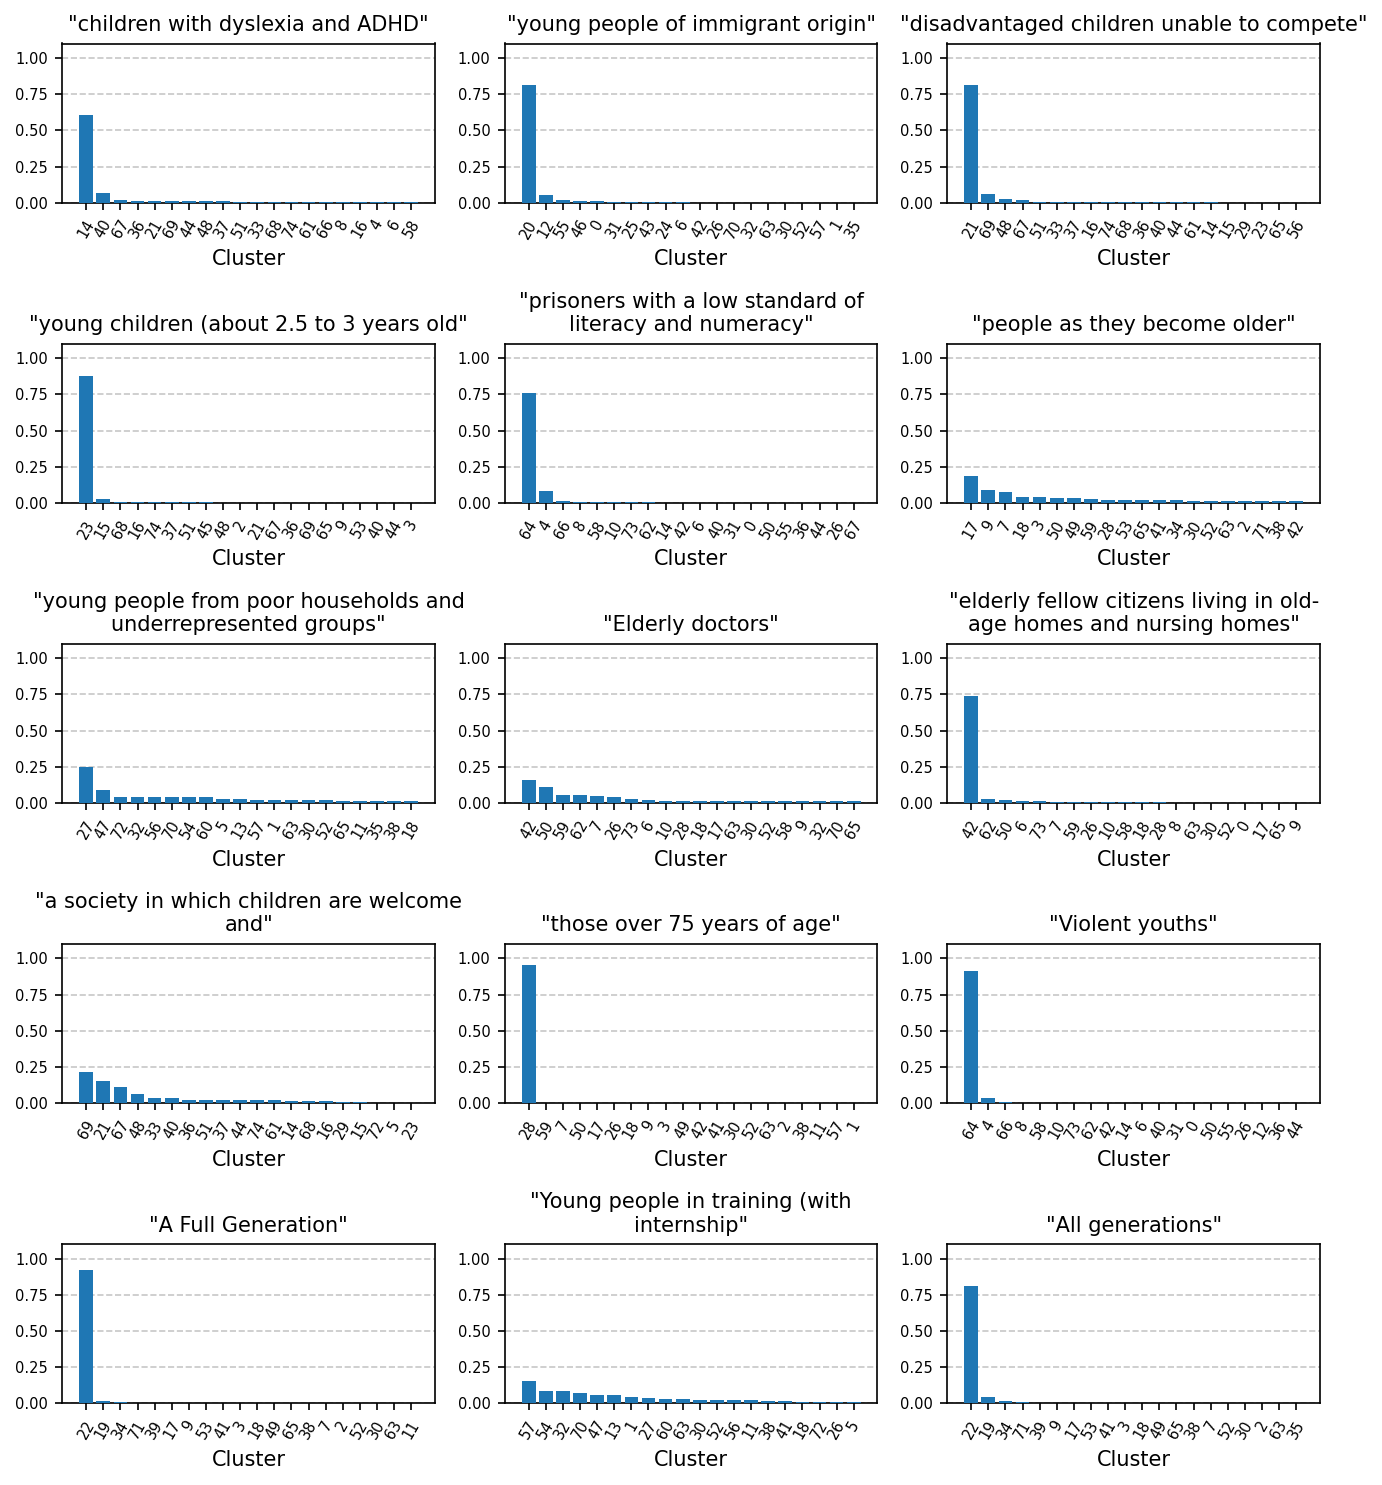

In [36]:
import numpy as np
from textwrap import fill
from matplotlib import pyplot as plt

n_col = 3
n_rows = 5
n_ = n_col * n_rows
frac_ = 1/3
fig, axes = plt.subplots(n_rows, n_col, figsize=(n_col*3, n_rows*2), dpi=150)
top_ = 20
for i, ax in enumerate(axes.flatten()):
    ax.set_ylim(0, 1.1)
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_yticklabels([f'{y:.2f}' for y in np.linspace(0, 1, 5)], fontsize=7)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    these = u[:, i].argsort()[::-1][:top_]
    ax.bar(range(top_), u[these, i], zorder=3)
    ax.set_xticks(range(top_))
    ax.set_xticklabels(these, rotation=60, va='top', ha='center', fontsize=7)
    ax.set_xlabel('Cluster')
    m = fill(df_sample.text.iloc[i], width=40, break_long_words=False)
    ax.set_title(f'"{m}"', fontdict={'fontsize': 10})
plt.tight_layout()

In [37]:
from scipy.stats import entropy

def compute_membership_entropy(u_matrix, base=2):
    """
    Compute entropy for each sample's cluster membership distribution.
    
    Parameters:
    -----------
    u_matrix : numpy.ndarray
        Fuzzy membership matrix of shape (n_clusters, n_samples)
    base : int or float
        Logarithm base for entropy calculation (default=2 for bits)
        Use base=np.e for nats, base=10 for dits
    
    Returns:
    --------
    entropies : numpy.ndarray
        Entropy for each sample (length n_samples)
    """
    # Compute entropy for each sample (column)
    entropies = np.apply_along_axis(lambda col: entropy(col, base=base), axis=0, arr=u_matrix)
    return entropies

# Compute entropies for all samples
entropies = compute_membership_entropy(u)

# Normalized entropy (0 to 1 scale)
max_entropy = np.log2(k)  # Maximum possible entropy for k clusters
normalized_entropies = entropies / max_entropy

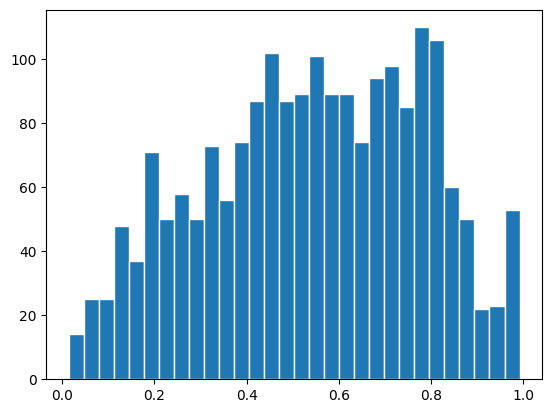

In [38]:
plt.hist(normalized_entropies, bins=30, edgecolor='white')
plt.show()

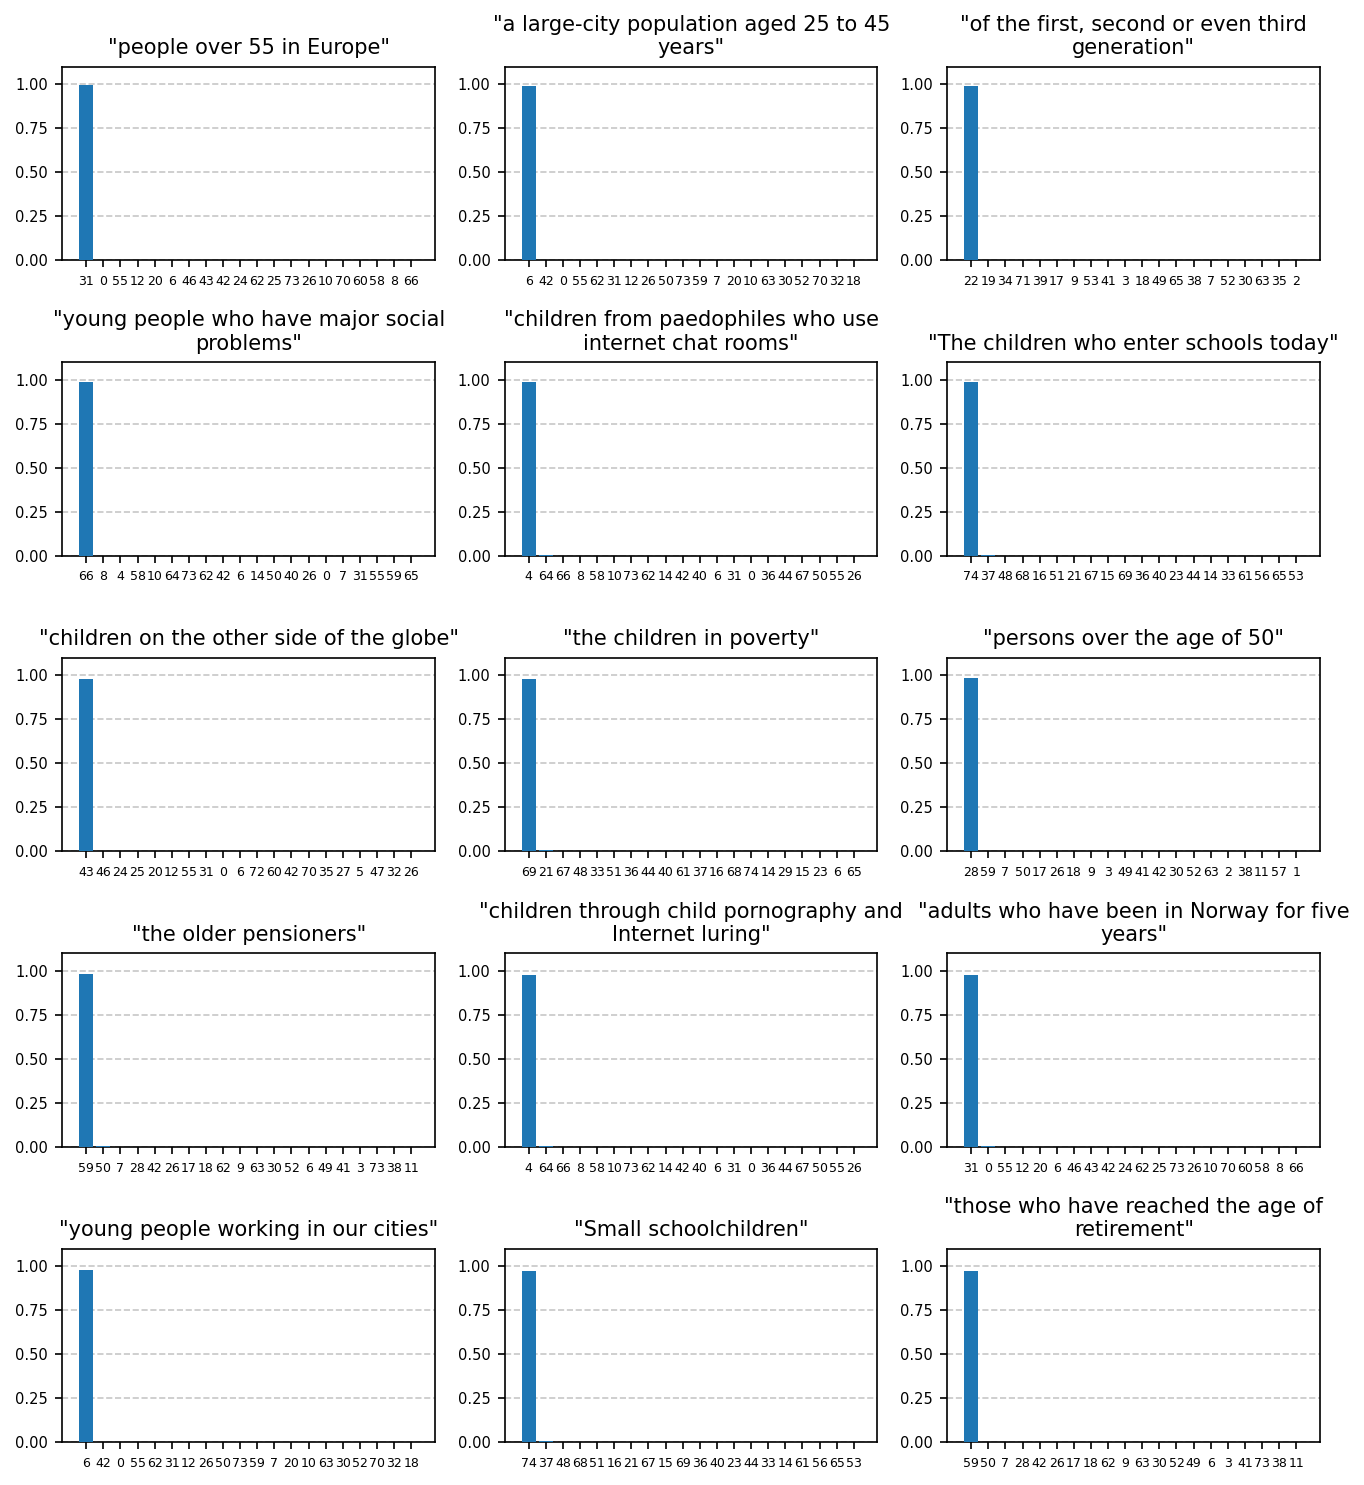

In [39]:
# plot most certain samples
n_col = 3
n_rows = 5
n_ = n_col * n_rows
most_certain = normalized_entropies.argsort()[:n_]
frac_ = 1/3
fig, axes = plt.subplots(n_rows, n_col, figsize=(n_col*3, n_rows*2), dpi=150)
top_ = 20
for i, ax in zip(most_certain, axes.flatten()):
    ax.set_ylim(0, 1.1)
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_yticklabels([f'{y:.2f}' for y in np.linspace(0, 1, 5)], fontsize=7)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    these = u[:, i].argsort()[::-1][:top_]
    ax.bar(range(top_), u[these, i], zorder=3)
    ax.set_xticks(range(top_))
    ax.set_xticklabels(these, va='top', ha='center', fontsize=6)
    # ax.set_xlabel('Cluster')
    m = fill(df_sample.text.iloc[i], width=40, break_long_words=False)
    ax.set_title(f'"{m}"', fontdict={'fontsize': 10})
plt.tight_layout()

In [40]:
def get_represenatative_texts(cluster_nr, top_n=20):
    idxs = u[cluster_nr, :].argsort()[::-1][:top_n]
    vals = u[cluster_nr, idxs]
    texts = df_sample.text.iloc[idxs].tolist()
    return pd.DataFrame({'text': texts, 'cluster_id': cluster_nr*top_n, 'membership_value': vals})

# representatives of cluster 14
def plot_representative_texts(cluster_nr, top_n=20):
    idxs = u[cluster_nr, :].argsort()[::-1][:top_n]
    vals = u[cluster_nr, idxs]

    # plot vals as horizontal bar chart
    plt.figure(figsize=(8, top_n/5), dpi=150)
    plt.barh(range(len(idxs)), vals, zorder=3)
    plt.gca().invert_yaxis()
    plt.yticks(
        range(len(idxs)), 
        df_sample.text.iloc[idxs].map(lambda x: fill(x, width=40, break_long_words=False)),
        fontsize=7
    )
    plt.show()  

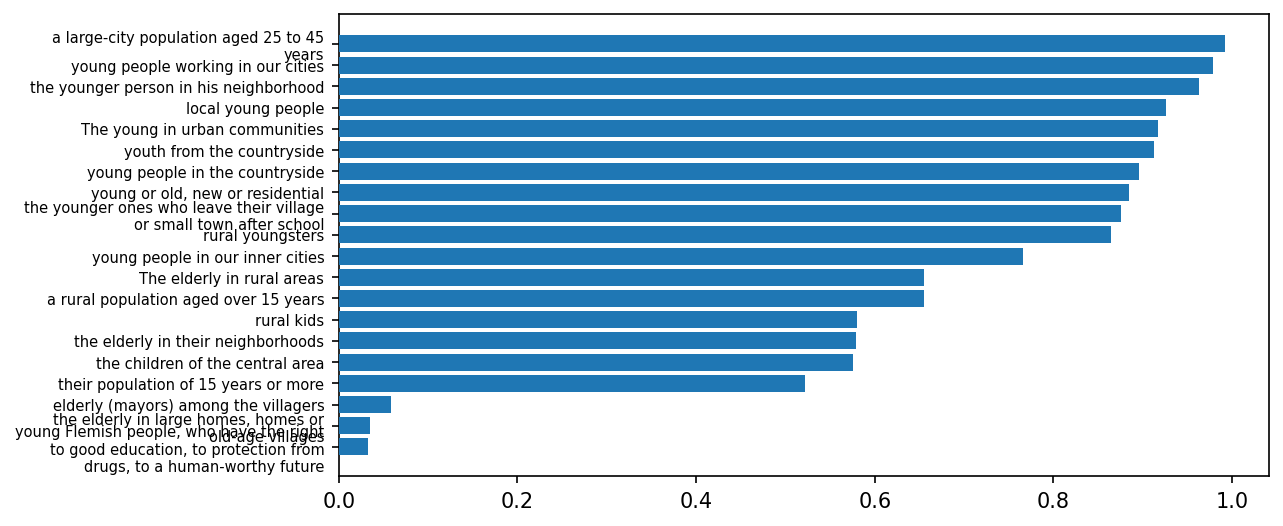

In [41]:
# young people
plot_representative_texts(cluster_nr = 6)

In [42]:
# age + country/region
get_represenatative_texts(cluster_nr = 31)

,text,cluster_id,membership_value
0,people over 55 in Europe,620,0.993654
1,adults who have been in Norway for five years,620,0.978231
2,Denmarks many elderly,620,0.919171
3,"our seniors, who have rebuilt Austria",620,0.906573
4,young people in Western Europe,620,0.899880
5,"adult, working people in Norway",620,0.841009
6,The elderly in Sweden,620,0.825782
7,Swedens elderly people,620,0.805823
8,young people in Belgium,620,0.720014
9,the elderly in Estonia,620,0.662890


In [43]:
# pensioners / retirees / retirement
get_represenatative_texts(cluster_nr = 59)

,text,cluster_id,membership_value
0,the older pensioners,1180,0.980602
1,those who have reached the age of retirement,1180,0.974968
2,early retirees,1180,0.894172
3,pensioners of the future,1180,0.887815
4,those who retire earlier,1180,0.841771
5,retirees of living,1180,0.837388
6,potential IV pensioners,1180,0.828259
7,those in retirement,1180,0.823583
8,holders of personal pensions aged 30 and over,1180,0.816820
9,"all people, whether working or not, in old age",1180,0.800453


In [44]:
# poor children (!!!)
get_represenatative_texts(cluster_nr = 69)

,text,cluster_id,membership_value
0,the children in poverty,1380,0.979407
1,children in poverty,1380,0.894944
2,children out of poverty,1380,0.866222
3,children in low income communities,1380,0.859963
4,children in poor communities,1380,0.786494
5,children from poverty and exclusion,1380,0.764908
6,children from resource-poor homes,1380,0.746750
7,children living below the poverty line - most ...,1380,0.701126
8,children who do not have a roof over their heads,1380,0.608166
9,children which limit the impact of poverty on ...,1380,0.516388


In [45]:
# school children
get_represenatative_texts(cluster_nr = 74)

,text,cluster_id,membership_value
0,The children who enter schools today,1480,0.987111
1,Small schoolchildren,1480,0.975882
2,all primary schoolchildren,1480,0.945575
3,kindergart,1480,0.887372
4,schoolchildren,1480,0.877905
5,all primary school children,1480,0.873184
6,secondary school children,1480,0.863416
7,all school children up to and including year 12,1480,0.852625
8,every primary school child,1480,0.812185
9,primary school child,1480,0.792305


<BarContainer object of 75 artists>

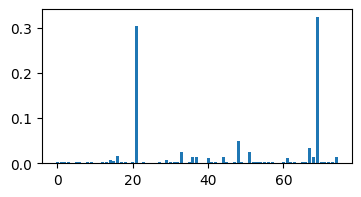

In [46]:
idx = np.where(df_sample.text=="low income kids")[0][0]
plt.figure(figsize=(4, 2))
plt.bar(range(u.shape[0]), u[:, idx])

In [47]:
# get most probably clusters for "low income kids	"
idxs = u[:, idx].argsort()[::-1][:10]
vals = u[idxs, idx]
dict(zip(idxs, vals))
# so "low income kids" is primarily a mixture of cluster 69 (poor children) and 21 (disadvantaged children)

{69: 0.32423852336209236,
 21: 0.30448569405565273,
 48: 0.04914833729756819,
 67: 0.034168267953376054,
 33: 0.02531762997816288,
 51: 0.024190185881287782,
 16: 0.015281057710757004,
 36: 0.014382342083283506,
 37: 0.014077281387406297,
 44: 0.013541326629799797}

In [48]:
get_represenatative_texts(cluster_nr = 21)

,text,cluster_id,membership_value
0,Children from socially deprived backgrounds,420,0.850800
1,children from less advantaged backgrounds,420,0.848024
2,disadvantaged children unable to compete,420,0.812512
3,Children from disadvantaged groups,420,0.781063
4,able children from poorer backgrounds,420,0.765881
5,disadvantaged children,420,0.747631
6,"children who, as the weak of society, are stru...",420,0.726772
7,the poorest children,420,0.724855
8,"talented children, from less well-off backgrounds",420,0.629040
9,children from other marginalized groups,420,0.494026


### get textual summaries of clusters

In [49]:
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import re
import nltk

nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Preprocess text: lowercase, remove punctuation/symbols/numbers
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # normalize whitespace
    return text

df_sample['text_clean'] = df_sample['text'].apply(preprocess_text)
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.sws = set(stopwords.words('english'))
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles) if t not in self.sws]

vectorizer = CountVectorizer(
    tokenizer=LemmaTokenizer(),
    token_pattern=None,
    ngram_range=(1, 3), 
    max_df = 0.5,
)

dtm = vectorizer.fit_transform(df_sample.text_clean.to_list())

In [50]:
from tqdm.auto import tqdm
from sklearn.linear_model import ElasticNetCV

feature_models = {}

cluster_ids = [
    6, # young people
    21, # disadvantaged children
    31, # adults
    59, # pensioners / retirement
    69, # children (?)
    74, # shool children
]  # clusters to model

for cluster_id in tqdm(cluster_ids):
    model = ElasticNetCV(
        l1_ratio=0.8,
        cv=5,
        fit_intercept=False,
        max_iter=10_000,
        n_jobs=-1,
        copy_X=False,
        random_state=42,
    )
    model.fit(dtm, u[cluster_id,: ])

    feature_models[cluster_id] = pd.DataFrame({
        "feature": vectorizer.get_feature_names_out(),
        "weight": model.coef_
    }).sort_values('weight', ascending=False)

  0%|          | 0/6 [00:00<?, ?it/s]

In [51]:
feature_models[6].head(10) # youth + location

,feature,weight
1661,countryside,0.823283
5818,rural,0.591129
4260,neighborhood,0.558751
3842,local young people,0.389253
3841,local young,0.389253
7555,young urban,0.257074
7556,young urban community,0.257074
6791,urban community,0.257074
5153,people working city,0.253027
7166,working city,0.253027


In [52]:
feature_models[21].head(10) # disadvantaged children

,feature,weight
1155,child less,0.520289
1974,disadvantaged child,0.519376
5301,poorest child,0.504997
1033,child disadvantaged,0.183941
1034,child disadvantaged group,0.183941
1978,disadvantaged group,0.183941
1545,community child,0.154543
3402,income kid,0.146130
3897,low income kid,0.146130
14,able child poorer,0.129118


In [53]:
feature_models[31].head(10) # elderly + location

,feature,weight
2402,europe,0.810453
2264,elderly sweden,0.442348
4364,norway,0.240711
3951,many elderly,0.219719
1828,denmark many elderly,0.219719
1827,denmark many,0.219719
6414,sweden elderly,0.214581
6415,sweden elderly people,0.214581
2392,estonia,0.213684
2195,elderly estonia,0.213684


In [54]:
feature_models[69].head(10) # child + poverty

,feature,weight
1257,child poverty,0.778674
3398,income community,0.356078
3896,low income community,0.356078
1252,child poor community,0.218384
5288,poor community,0.218384
1251,child poor,0.200852
1083,child friendly,0.136612
3331,housing allowance,0.115073
1118,child housing allowance,0.115073
1117,child housing,0.115073


In [55]:
feature_models[74].head(10) # school children

,feature,weight
5890,schoolchildren,0.694349
3579,kindergart,0.343589
5845,school child,0.291953
2346,enter school today,0.194544
5879,school today,0.194544
5398,primary school child,0.178458
5392,primary,0.109654
5841,school,0.056138
3095,grade,0.048806
5920,secondary school,0.020095


In [56]:
feature_models = {}

cluster_ids = range(u.shape[0])  # clusters to model

for cluster_id in tqdm(cluster_ids):
    # TODO: parallelize
    model = ElasticNetCV(
        l1_ratio=0.8,
        cv=5,
        fit_intercept=False,
        max_iter=10_000,
        n_jobs=-1,
        copy_X=False,
        random_state=42,
    )
    model.fit(dtm, u[cluster_id,: ])

    feature_models[cluster_id] = pd.DataFrame({
        "feature": vectorizer.get_feature_names_out(),
        "weight": model.coef_
    }).sort_values('weight', ascending=False)

  0%|          | 0/75 [00:00<?, ?it/s]

In [57]:
feat_weights = pd.concat(feature_models).reset_index(level=0, names=['cluster_id', 'row_id']).sort_values(['feature', 'weight'], ascending=[True, False])

##### heigh-weight feautures?

the feature models model an otucome in [0, 1]; coefficient estimates -> 1 mean high influence on cluster assignment

In [58]:
# heigh-weight feautures
feat_weights.groupby('feature').agg({'weight': lambda x: np.max(abs(x))}).reset_index().sort_values('weight', ascending=False).head(40)

,feature,weight
1661,countryside,0.823283
2402,europe,0.810453
3442,individual age,0.790583
1257,child poverty,0.778674
5331,posterity,0.774956
4699,parent young offender,0.761961
4772,pensioner,0.748443
4506,older people disability,0.735943
3413,income youth,0.729150
1373,child victim,0.721501


In [59]:
term = 'offender'
tmp = feat_weights[feat_weights.feature.str.contains(term)]
print(*tmp.feature.unique()[:10].tolist(), sep='\n')
tmp.loc[tmp.feature=="offender"].sort_values('weight', ascending=False)
# NOTE: this example shows that some terms are just not very influential

adolescent offender
adult ex offender
adult offender
adult offender released
backfall offender
backfall offender case
ex offender
first offender
juvenile offender
juvenile repeat offender


,cluster_id,feature,weight
4398,64,offender,0.550275
4398,4,offender,0.076039
4398,58,offender,0.003724
4398,56,offender,-0.000000
4398,39,offender,-0.000000
...,...,...,...
4398,38,offender,-0.004586
4398,63,offender,-0.004593
4398,30,offender,-0.004604
4398,52,offender,-0.004604


In [60]:
get_represenatative_texts(cluster_nr=64, top_n=10)

,text,cluster_id,membership_value
0,the youngest victims of crime,640,0.963808
1,young people in the modern world who become mo...,640,0.949689
2,young people aged 15-17 who commit serious crimes,640,0.928220
3,Young people who fall into crime,640,0.922668
4,Young Offenders,640,0.914343
5,Violent youths,640,0.911499
6,Adolescent offenders,640,0.905325
7,Young people who find themselves on probation ...,640,0.900219
8,Juvenile offenders,640,0.898850
9,young adult offenders,640,0.893807


In [114]:
tmp = feat_weights[feat_weights.feature.str.contains('military')]
print(*tmp.feature.unique()[:10].tolist(), sep='\n')
tmp.loc[tmp.feature=="military"].sort_values('weight', ascending=False)

american military
american military personnel
american serving military
certified military
certified military medical
future military
future military professional
healthy certified military
military
military action


,cluster_id,feature,weight
4215,23,military,0.101534
4215,71,military,0.039421
4215,38,military,0.011980
4215,64,military,0.002466
4215,16,military,0.001635
...,...,...,...
4215,29,military,0.000000
4215,31,military,0.000000
4215,32,military,0.000000
4215,33,military,0.000000


In [109]:
get_represenatative_texts(cluster_nr=23, top_n=10)

,text,cluster_id,membership_value
0,all military members,230,0.937691
1,the men and women of the Guard and Reserves,230,0.865163
2,any member of our armed forces,230,0.819910
3,uniformed warfighters who serve on the front l...,230,0.712756
4,national military contingents,230,0.709921
5,each surviving British nuclear-test veteran,230,0.688267
6,the men and women of todays Armed Forces,230,0.679192
7,"Those who, like our soldiers, take responsibil...",230,0.636626
8,the men and women of the Guard and Reserve,230,0.610688
9,"former members of the armed forces, who were w...",230,0.594143


In [110]:
get_represenatative_texts(cluster_nr=71, top_n=10)

,text,cluster_id,membership_value
0,"professional soldiers in the Army, Navy and Ai...",710,0.928072
1,infantry,710,0.747171
2,airmen,710,0.645048
3,light mountain infantry,710,0.643414
4,those in uniform,710,0.610595
5,Armed Forces personnel,710,0.584614
6,full time soldiers in the British Army,710,0.583589
7,our civilian reserve elements,710,0.528088
8,young recruits in the federal army,710,0.526829
9,cadet forces,710,0.500287


### induce hierarchical cluster

using the `u.T` as featueres, we can fit an agglomarative clustering tree to obtain the fuzzy clusters' hierarchcial relation

In [61]:
from sklearn.cluster import AgglomerativeClustering

# compute distances between samples fuzzy cluster memberships using thie Jensen-Shannon divergence


agglo_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0.5, linkage='ward')
agglo_model.fit(u)

,n_clusters,None
,metric,'euclidean'
,memory,None
,connectivity,None
,compute_full_tree,'auto'
,linkage,'ward'
,distance_threshold,0.5
,compute_distances,False


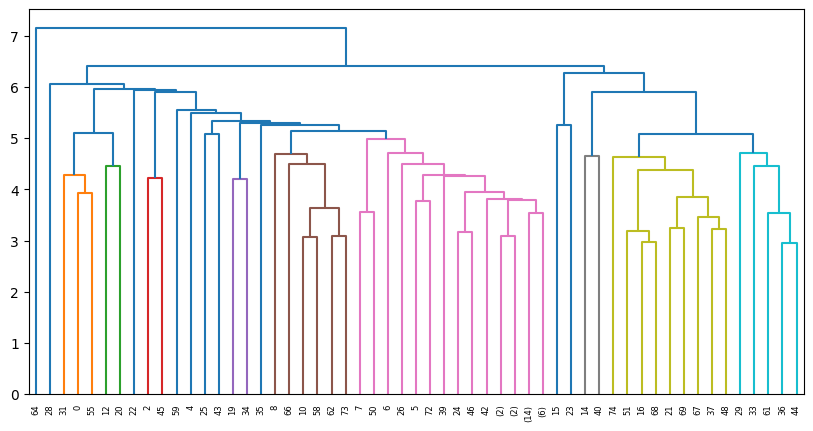

In [ ]:
# show dendrogram
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize=(10, 5))
plot_dendrogram(agglo_model, truncate_mode='level', p=20)